In [1]:
import sys
sys.path.append('../')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt

from util.true_gaussian_process import *

from ofm_OT_likelihood import *
from models.fno import FNO

import statsmodels.api as sm
from scipy.stats import binned_statistic
import os

In [2]:
train_samples = 20000


n_x = 128
dims = [n_x]


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
spath = Path('your_path/GP')
spath.mkdir(parents=True, exist_ok=True)
saved_model = True # save model

# FNO hyperparameters
modes = 32
width = 256
mlp_width = 128

# GP hyperparameters
kernel_length=0.01
kernel_variance=1
nu = 0.5 # default


## Dataset parameters
length_scale_x = 0.3
var_x = 1
nu_x = 1.5

## training parameters
epochs = 500
sigma_min=1e-4
N = 1
batch_size = 1024

torch.Size([20000, 1, 128])


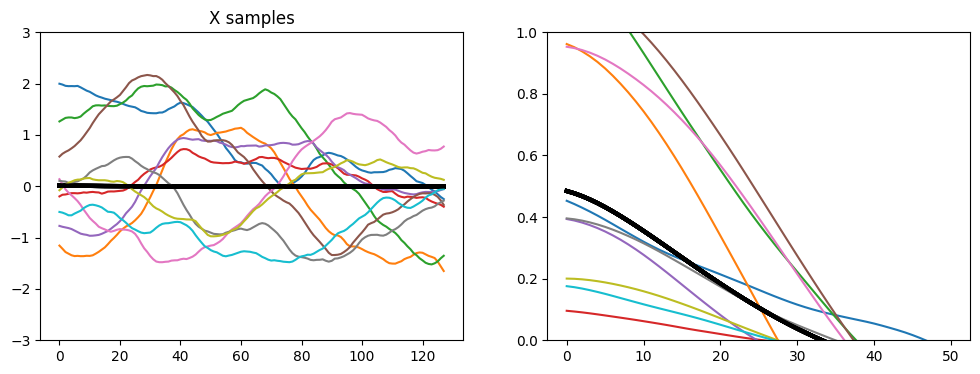

In [5]:
## Prepare training dataset

GP_1C = true_GPPrior(lengthscale=length_scale_x, var=var_x, nu=nu_x, device=device, dims=dims)
x_train = GP_1C.sample_train_data(dims=dims, n_samples=train_samples)


loader_tr = DataLoader(x_train, batch_size=batch_size, shuffle=True)

fig, ax = plt.subplots(1,2, figsize=(12,4))
x_mean_true = x_train.mean(dim=0).squeeze()
x_hist_true, bin_edges = x_train.histogram(range=[-4,4], density=True)

# calculate the autocovaraince
x_acovf_true = torch.stack([torch.tensor(sm.tsa.acovf(x_train[i,0,:].numpy(), nlag=50)) for i in range(train_samples)]).mean(dim=0)
#train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train), batch_size=batch_size, shuffle=True)

print(x_train.shape)
for i in range(10):
    x = x_train[i,0]
    ax[0].plot(x)
    ax[0].set_ylim([-3, 3])
    ax[0].plot(x_mean_true, c='k', lw=3)
    ax[0].set_title("X samples")
    ax[1].plot(x_acovf_true, c='k', lw=3)
    ax[1].plot(sm.tsa.acovf(x, nlag=50))
    ax[1].set_ylim([0.0, 1.0])
plt.show()


In [4]:
for i in range(N):
    model = FNO(modes, vis_channels=1, hidden_channels=width, proj_channels=mlp_width, x_dim=1, t_scaling=1).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.8)
    fmot = OFMModel(model, kernel_length=kernel_length, kernel_variance=kernel_variance, nu=nu, sigma_min=sigma_min, device=device, dims=dims)
    fmot.train(loader_tr, optimizer, epochs=epochs, scheduler=scheduler, eval_int=int(0), save_int=int(500), generate=False, save_path=spath,saved_model=saved_model)
    #samplefmot_original[i,:,:, :] = fmot.sample([n_x, n_x], n_samples=n_gen_samples).cpu().squeeze()


tr @ epoch 1/500 | Loss 0.885476 | 5.76 (s)
tr @ epoch 2/500 | Loss 0.377904 | 5.52 (s)
tr @ epoch 3/500 | Loss 0.256069 | 5.71 (s)
tr @ epoch 4/500 | Loss 0.207328 | 5.51 (s)
tr @ epoch 5/500 | Loss 0.181323 | 5.55 (s)
tr @ epoch 6/500 | Loss 0.169275 | 5.50 (s)
tr @ epoch 7/500 | Loss 0.161097 | 5.52 (s)
tr @ epoch 8/500 | Loss 0.152528 | 5.52 (s)
tr @ epoch 9/500 | Loss 0.150898 | 5.52 (s)
tr @ epoch 10/500 | Loss 0.149180 | 5.54 (s)
tr @ epoch 11/500 | Loss 0.146016 | 5.55 (s)
tr @ epoch 12/500 | Loss 0.145993 | 5.53 (s)
tr @ epoch 13/500 | Loss 0.146629 | 5.59 (s)
tr @ epoch 14/500 | Loss 0.146163 | 5.55 (s)
tr @ epoch 15/500 | Loss 0.146209 | 5.54 (s)
tr @ epoch 16/500 | Loss 0.152019 | 5.54 (s)
tr @ epoch 17/500 | Loss 0.144612 | 5.55 (s)
tr @ epoch 18/500 | Loss 0.143790 | 5.52 (s)
tr @ epoch 19/500 | Loss 0.141736 | 5.54 (s)
tr @ epoch 20/500 | Loss 0.139177 | 5.54 (s)
tr @ epoch 21/500 | Loss 0.143518 | 5.55 (s)
tr @ epoch 22/500 | Loss 0.143239 | 5.51 (s)
tr @ epoch 23/500 |

tr @ epoch 182/500 | Loss 0.136272 | 5.51 (s)
tr @ epoch 183/500 | Loss 0.135734 | 5.49 (s)
tr @ epoch 184/500 | Loss 0.135648 | 5.45 (s)
tr @ epoch 185/500 | Loss 0.134869 | 5.48 (s)
tr @ epoch 186/500 | Loss 0.134663 | 5.54 (s)
tr @ epoch 187/500 | Loss 0.134996 | 5.50 (s)
tr @ epoch 188/500 | Loss 0.136525 | 5.52 (s)
tr @ epoch 189/500 | Loss 0.135947 | 5.54 (s)
tr @ epoch 190/500 | Loss 0.134705 | 5.54 (s)
tr @ epoch 191/500 | Loss 0.134578 | 5.52 (s)
tr @ epoch 192/500 | Loss 0.135354 | 5.52 (s)
tr @ epoch 193/500 | Loss 0.135867 | 5.52 (s)
tr @ epoch 194/500 | Loss 0.134508 | 5.53 (s)
tr @ epoch 195/500 | Loss 0.134263 | 5.51 (s)
tr @ epoch 196/500 | Loss 0.136147 | 5.52 (s)
tr @ epoch 197/500 | Loss 0.137914 | 5.51 (s)
tr @ epoch 198/500 | Loss 0.135346 | 5.55 (s)
tr @ epoch 199/500 | Loss 0.135827 | 5.53 (s)
tr @ epoch 200/500 | Loss 0.135538 | 5.53 (s)
tr @ epoch 201/500 | Loss 0.134787 | 5.55 (s)
tr @ epoch 202/500 | Loss 0.133409 | 5.49 (s)
tr @ epoch 203/500 | Loss 0.135053

tr @ epoch 361/500 | Loss 0.134027 | 5.52 (s)
tr @ epoch 362/500 | Loss 0.135259 | 5.53 (s)
tr @ epoch 363/500 | Loss 0.132812 | 5.54 (s)
tr @ epoch 364/500 | Loss 0.134646 | 5.51 (s)
tr @ epoch 365/500 | Loss 0.134557 | 5.56 (s)
tr @ epoch 366/500 | Loss 0.135215 | 5.52 (s)
tr @ epoch 367/500 | Loss 0.133998 | 5.55 (s)
tr @ epoch 368/500 | Loss 0.134082 | 5.52 (s)
tr @ epoch 369/500 | Loss 0.132763 | 5.53 (s)
tr @ epoch 370/500 | Loss 0.134144 | 5.54 (s)
tr @ epoch 371/500 | Loss 0.134370 | 5.53 (s)
tr @ epoch 372/500 | Loss 0.133964 | 5.54 (s)
tr @ epoch 373/500 | Loss 0.134101 | 5.52 (s)
tr @ epoch 374/500 | Loss 0.133207 | 5.53 (s)
tr @ epoch 375/500 | Loss 0.134237 | 5.51 (s)
tr @ epoch 376/500 | Loss 0.134721 | 5.52 (s)
tr @ epoch 377/500 | Loss 0.134219 | 5.52 (s)
tr @ epoch 378/500 | Loss 0.134433 | 5.56 (s)
tr @ epoch 379/500 | Loss 0.134029 | 5.57 (s)
tr @ epoch 380/500 | Loss 0.133222 | 5.55 (s)
tr @ epoch 381/500 | Loss 0.133488 | 5.51 (s)
tr @ epoch 382/500 | Loss 0.133719

## evaluation

In [9]:
## load trained model
model = FNO(modes, vis_channels=1, hidden_channels=width, proj_channels=mlp_width, x_dim=1, t_scaling=1).to(device)
    
for param in model.parameters():
    param.requires_grad = False
    
# paper :model_path = path "paper_saved_models/{}/1D_codomain_649_set1.pt".format(folder)
model_path = os.path.join(spath, 'epoch_500.pt')
checkpoint = torch.load(model_path, map_location='cpu', weights_only=True)
model.load_state_dict(checkpoint)

fmot = OFMModel(model, kernel_length=kernel_length, kernel_variance=kernel_variance, nu=nu, sigma_min=sigma_min, device=device, dims=dims)

## statistical features

In [6]:
#Generation_results
paper_path = '../Generation_results/GP'

if not os.path.exists(f"../Regression_results/{paper_path}"):
    os.makedirs(f"../Regression_results/{paper_path}")

In [7]:
x_train = GP_1C.sample_train_data(dims=dims, n_samples=train_samples) # x_train is the test data
x_hist_true, bin_edges = x_train.histogram(range=[-4,4], density=True)
x_pos = np.linspace(0, 1, n_x)

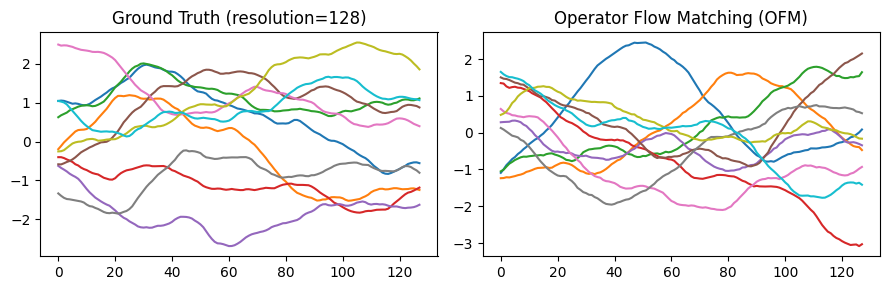

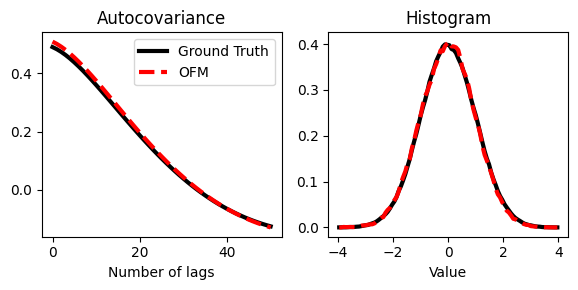

In [9]:
with torch.no_grad():
    X_hat = fmot.sample([n_x], n_samples=10, n_eval=10).cpu().squeeze()
    X_ground_truth = x_train[:10].squeeze()
    # plot
    fig, ax = plt.subplots(1,2, figsize=(9,3))
    
    X_alt = []
    for i in range(3):
        X_temp = fmot.sample([n_x], n_samples=1000, n_eval=10).cpu().squeeze()
        X_alt.append(X_temp)
        
    X_alt = torch.vstack(X_alt)
    
    x_hist, bin_edges_alt = X_alt.histogram(range=[-4,4], density=True)    
    for i in range(10):
        x = X_hat[i,:]
        x_ground_truth = X_ground_truth[i,:]
        ax[0].plot(x_ground_truth)
        ax[0].set_title('Ground Truth (resolution={})'.format(n_x))
        ax[1].plot(x)
        ax[1].set_title('Operator Flow Matching (OFM)')
        #ax[0].set_ylim([-3, 3])
        #ax[1].plot(sm.tsa.acovf(x, nlag=50))
        #ax[1].set_ylim([0.0, 1.0])
    plt.tight_layout()
    plt.savefig(f"../Regression_results/{paper_path}/GP_samples.pdf")
    
    x_mean = X_alt.mean(dim=0)
    x_acovf = torch.stack([torch.tensor(sm.tsa.acovf(X_alt[i, :], nlag=50)) for i in range(3000)]).mean(dim=0)
    
    fig, ax = plt.subplots(1,2, figsize=(6,3))
    ax[0].plot(x_acovf_true, c='k', lw=3, label='Ground Truth')
    ax[0].plot(x_acovf, c='r',ls='--', lw=3, label='OFM')
    #ax[1].set_ylim([0,0.5])
    ax[0].set_xlabel('Number of lags')
    ax[0].set_title('Autocovariance')
    ax[1].plot((bin_edges[1:]+bin_edges[:-1])/2, x_hist_true, c='k', lw=3)
    ax[1].plot((bin_edges_alt[1:]+bin_edges_alt[:-1])/2, x_hist, c='r', ls='--', lw=3)
    ax[1].set_title('Histogram')
    ax[1].set_xlabel('Value')
    ax[0].legend(loc='upper right')
    plt.tight_layout()
    plt.savefig(f"../Regression_results/{paper_path}/GP_stat.pdf")

## super-resolution

In [10]:
#n_x_sup_all = [256, 512]
#nlag_sup_all = [100, 200]
n_x_sup = 512
nlag_sup = 200

In [11]:
train_samples_sup = 3000
GP_1C_sup = true_GPPrior(lengthscale=length_scale_x, var=var_x, nu=nu_x, device=device, dims=[n_x_sup])
x_train_sup = GP_1C_sup.sample_train_data(dims=[n_x_sup], n_samples=train_samples_sup)

x_hist_true_sup, bin_edges = x_train_sup.histogram(range=[-4,4], density=True)
x_pos = np.linspace(0, 1, n_x_sup)
x_mean_true_sup = x_train_sup.mean(dim=0).squeeze()
x_acovf_true_sup = torch.stack([torch.tensor(sm.tsa.acovf(x_train_sup[i,0,:].numpy(), nlag=nlag_sup)) for i in range(train_samples_sup)]).mean(dim=0)


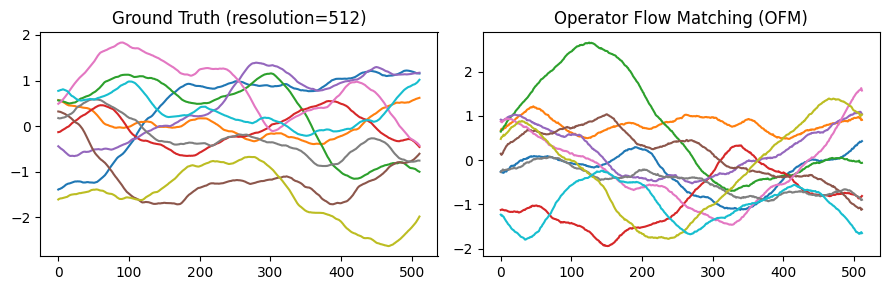

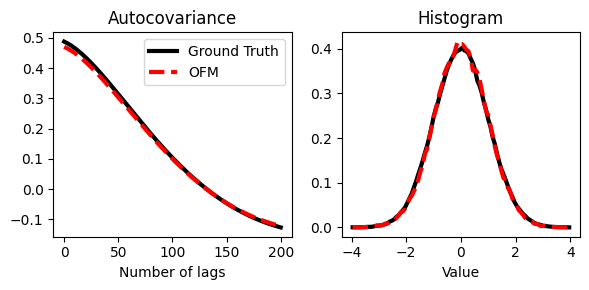

In [12]:
with torch.no_grad():
    X_hat = fmot.sample([n_x_sup], n_samples=10, n_eval=10).cpu().squeeze()
    X_ground_truth = x_train_sup[:10].squeeze()

    fig, ax = plt.subplots(1,2, figsize=(9,3))    
    X_alt = []
    for i in range(3):
        X_temp = fmot.sample([n_x_sup], n_samples=1000, n_eval=10).cpu().squeeze()
        X_alt.append(X_temp)
        
    X_alt = torch.vstack(X_alt)
    
    x_hist, bin_edges_alt = X_alt.histogram(range=[-4,4], density=True)    
    for i in range(10):
        x = X_hat[i,:]
        x_ground_truth = X_ground_truth[i,:]
        ax[0].plot(x_ground_truth)
        ax[0].set_title('Ground Truth (resolution={})'.format(n_x_sup))
        ax[1].plot(x)
        ax[1].set_title('Operator Flow Matching (OFM)')
        #ax[0].set_ylim([-3, 3])
        #ax[1].plot(sm.tsa.acovf(x, nlag=50))
        #ax[1].set_ylim([0.0, 1.0])
    plt.tight_layout()
    #plt.savefig(f"../Regression_results/{paper_path}/GP_samples_sup_{n_x_sup}.pdf")
    
    x_mean = X_alt.mean(dim=0)
    x_acovf = torch.stack([torch.tensor(sm.tsa.acovf(X_alt[i, :], nlag=nlag_sup)) for i in range(3000)]).mean(dim=0)
    
    fig, ax = plt.subplots(1,2, figsize=(6,3))
    ax[0].plot(x_acovf_true_sup, c='k', lw=3, label='Ground Truth')
    ax[0].plot(x_acovf, c='r',ls='--', lw=3, label='OFM')
    #ax[1].set_ylim([0,0.5])
    ax[0].set_xlabel('Number of lags')
    ax[0].set_title('Autocovariance')
    ax[1].plot((bin_edges[1:]+bin_edges[:-1])/2, x_hist_true, c='k', lw=3)
    ax[1].plot((bin_edges_alt[1:]+bin_edges_alt[:-1])/2, x_hist, c='r', ls='--', lw=3)
    ax[1].set_title('Histogram')
    ax[1].set_xlabel('Value')
    ax[0].legend(loc='upper right')
    plt.tight_layout()
    #plt.savefig(f"../Regression_results/{paper_path}/GP_stat_sup_{n_x_sup}.pdf")